## 3C - L2 Camera Intrinsic and Extrinsic Parameters

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.rotations as pr
from pytransform3d.plot_utils import plot_vector

### Extrinsic Parameters

#### Rotation

In [2]:
def get_rot_x(angle):
    '''
    Rotation about the standard X axis
    '''
    Rx = np.zeros(shape=(3, 3))
    Rx[0, 0] = 1
    Rx[1, 1] = np.cos(angle)
    Rx[1, 2] = -np.sin(angle)
    Rx[2, 1] = np.sin(angle)
    Rx[2, 2] = np.cos(angle)
    
    return Rx

def get_rot_y(angle):
    '''
    Rotation about the standard Y axis
    '''
    Ry = np.zeros(shape=(3, 3))
    Ry[0, 0] = np.cos(angle)
    Ry[0, 2] = -np.sin(angle)
    Ry[2, 0] = np.sin(angle)
    Ry[2, 2] = np.cos(angle)
    Ry[1, 1] = 1
    
    return Ry

def get_rot_z(angle):
    '''
    Rotation about the standard Z axis
    '''
    Rz = np.zeros(shape=(3, 3))
    Rz[0, 0] = np.cos(angle)
    Rz[0, 1] = -np.sin(angle)
    Rz[1, 0] = np.sin(angle)
    Rz[1, 1] = np.cos(angle)
    Rz[2, 2] = 1
    
    return Rz

In [3]:
def create_rotation_matrix_extrinsic(angles, order):
    '''
    Create a matrix that rotates a vector through the given angles in the given order
    wrt the standard global axes (extrinsic rotation)
    Note: The rotation is carried out anticlockwise in a left handed axial system
    '''
    fn_mapping = {'x': get_rot_x, 'y': get_rot_y, 'z': get_rot_z}
    net = np.identity(3)
    for angle, axis in list(zip(angles, order))[::-1]:
        if fn_mapping.get(axis) is None:
            raise ValueError("Invalid axis")
        R = fn_mapping.get(axis)
        net = np.matmul(net, R(angle))
        
    return net

In [4]:
angles = [np.pi/4, np.pi/4]
order = 'zy'
R = create_rotation_matrix_extrinsic(angles, order)

Text(0.5, 0, 'Z-axis')

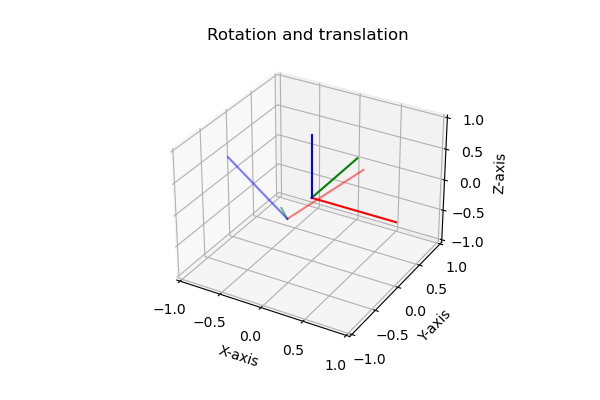

In [5]:
# create figure
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

# set axis limits
ax.set(xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1))

# plot the standard global basis
ax = pr.plot_basis(ax)

# plot the transformed basis
ax = pr.plot_basis(ax, R, alpha=0.5, p=np.array([0, -0.5, 0]))

# set labels
ax.set_title("Rotation and translation")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

Perfect

#### Extrinsic Parameter Matrix

In [6]:
def create_extrinsic_matrix(angles, order, translation):
    '''
    Combine rotation and translation and create an extrinsic camera matrix which
    transforms homogeneous coordinates in world space to euclidean coordinates
    in the camera frame
    '''
    R = create_rotation_matrix_extrinsic(angles, order)
    t = translation.reshape(3, 1)
    return np.hstack((R, t))

In [7]:
# basis in homogeneous coordinates
xh = np.array([1, 0, 0, 1])
yh = np.array([0, 1, 0, 1])
zh = np.array([0, 0, 1, 1])

t = np.array([0, -0.5, 0])

In [8]:
E = create_extrinsic_matrix(angles, order, t)

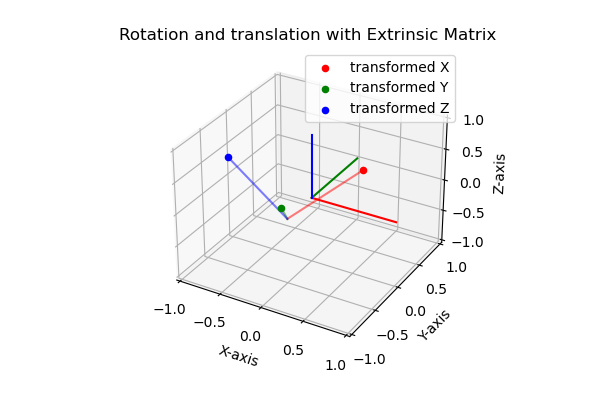

In [9]:
# create figure
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

# set axis limits
ax.set(xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1))

# plot the standard global basis
ax = pr.plot_basis(ax)

# plot the transformed basis
ax = pr.plot_basis(ax, R, alpha=0.5, p=np.array([0, -0.5, 0]))

# validate the extrinsic camera matrix
xt = np.matmul(E, xh.reshape(4, 1))
yt = np.matmul(E, yh.reshape(4, 1))
zt = np.matmul(E, zh.reshape(4, 1))

ax.scatter(*xt, label="transformed X", color="red")
ax.scatter(*yt, label="transformed Y", color="green")
ax.scatter(*zt, label="transformed Z", color="blue")

# set labels
ax.set_title("Rotation and translation with Extrinsic Matrix")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.legend()

Perfect

### Intrinsic Parameters

#### plot image plane

We're deadling with a left handed axial system here, hence we assume the camera points towards the positive Z axis.

The idea is to first plot the image plane with the given size and focal length in the standard world space, then transform it using the extrinsic camera matrix. The focal length would remain the same as it's just a translation and rotation, we're not doing any scaling here.

In [49]:
# define the focal length and the image size
f = 2 # f > 0
img_size = (7, 7)

h, w = img_size
xx, yy = np.meshgrid(range(-(h // 2), w // 2 + 1), range(-(h // 2), w // 2 + 1))
Z = np.ones(shape=img_size) * f

Text(0.5, 0, 'Z-axis')

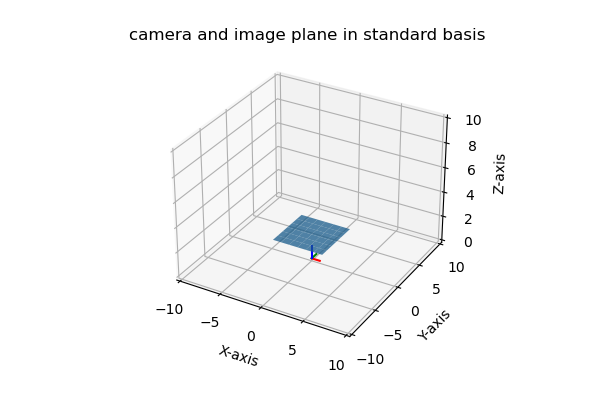

In [108]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

ax.plot_surface(xx, yy, Z, alpha=0.75)

ax.set(xlim=(-10, 10), ylim=(-10, 10), zlim=(0, 10))
ax = pr.plot_basis(ax)

ax.set_title("camera and image plane in standard basis")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

##### Transform the plane

Represent the image grid in homogeneous coordinates and transform it using the extrinsic matrix

In [57]:
pi = np.ones(shape=(4, h*w))
c = 0
for i in range(h):
    for j in range(w):
        x = xx[i, j]
        y = yy[i, j]
        z = Z[i, j]
        point = np.array([x, y, z])
        pi[:3, c] = point
        c += 1

In [109]:
angles = [np.pi/4]
order = "y"

t = np.array([0, -5, 0])
E = create_extrinsic_matrix(angles, order, t)

In [110]:
R = E[:3, :3]

Text(0.5, 0, 'Z-axis')

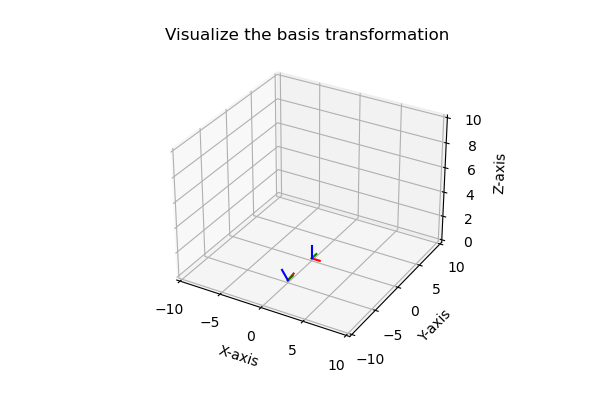

In [113]:
# create figure
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

# set axis limits
ax.set(xlim=(-10, 10), ylim=(-10, 10), zlim=(0, 10))

# plot the standard global basis
ax = pr.plot_basis(ax)

# plot the transformed basis
ax = pr.plot_basis(ax, R, p=t)

# set labels
ax.set_title("Visualize the basis transformation")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")


In [97]:
pt = np.matmul(E, pi)

In [98]:
pt.shape

(3, 49)

In [99]:
# separate x, y, z and construct a grid from the transformed points
xxt = pt[0, :].reshape(img_size)
yyt = pt[1, :].reshape(img_size)
Zt = pt[2, :].reshape(img_size)

Text(0.5, 0, 'Z-axis')

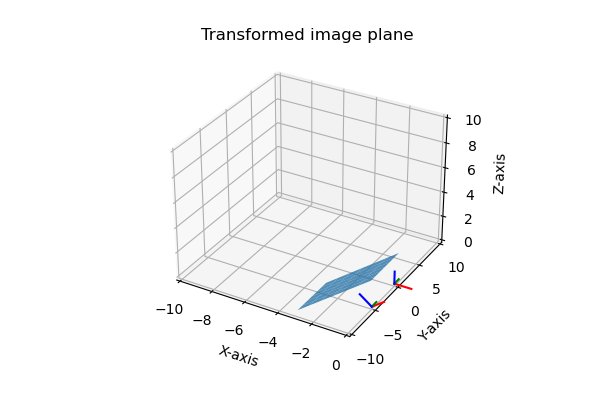

In [114]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

ax.set(xlim=(-10, 0), ylim=(-10, 10), zlim=(0, 10))

ax = pr.plot_basis(ax)

# the transformed image plane
ax.plot_surface(xxt, yyt, Zt, alpha=0.75)
# the transformed camera
ax = pr.plot_basis(ax, R, p=t)

ax.set_title("Transformed image plane")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

#### Plot random points in the world space

Text(0.5, 0, 'Z-axis')

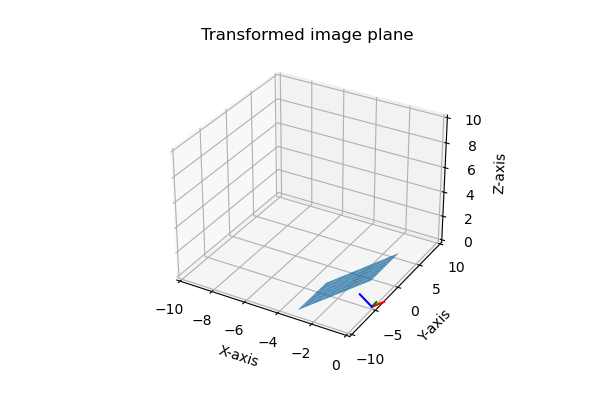

In [115]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

ax.set(xlim=(-10, 0), ylim=(-10, 10), zlim=(0, 10))

# the transformed image plane
ax.plot_surface(xxt, yyt, Zt, alpha=0.75)
# the transformed camera
ax = pr.plot_basis(ax, R, p=t)

ax.set_title("Transformed image plane")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")